In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
from scipy import stats
%matplotlib inline

In [3]:
train = pd.read_excel("train.xlsx")
test = pd.read_excel("test.xlsx")

In [ ]:
num_data = train.select_dtypes([np.number])
num_cols = num_data.columns
cat_cols = [column for column in train.columns if column not in num_cols]

Проверим tutor_reviews tutor_rating mean_price на нормальность распределения

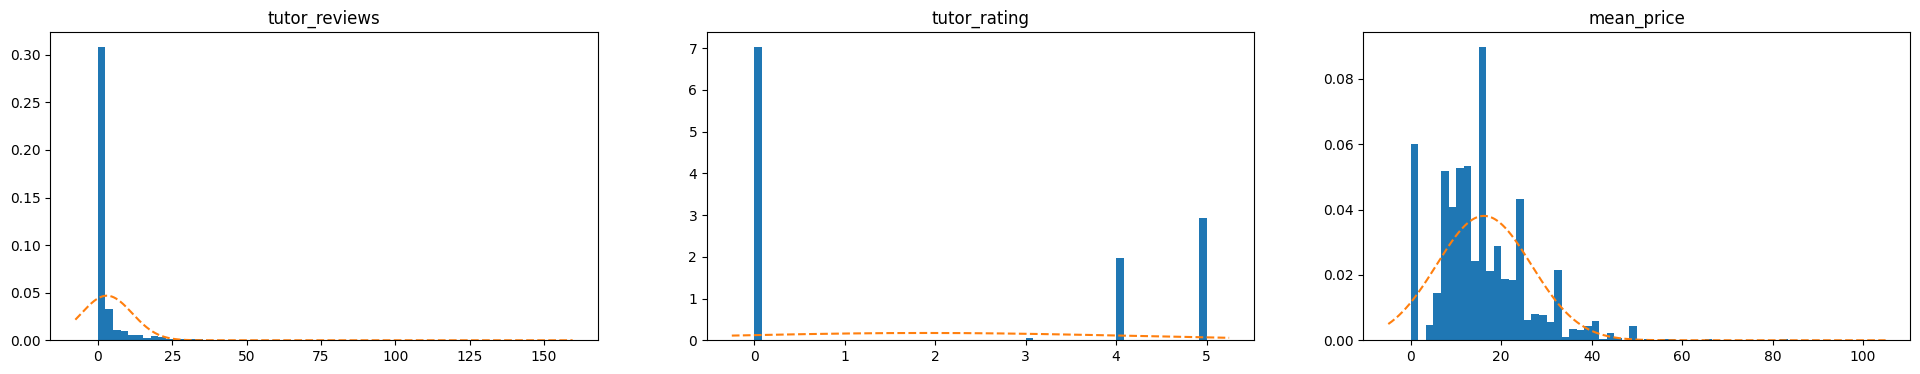

In [5]:
keys = ['tutor_reviews', 'tutor_rating', 'mean_price']

fig, axes = plt.subplots(ncols=len(keys))
fig.set_size_inches(8 * len(keys), 4)
axes = axes.flatten()

for key, ax in zip(keys, axes):
    ax.hist(train[key], density=True, bins=60)
    
    loc = train[key].mean()
    scale = train[key].std()
    
    x_left, x_right = ax.get_xlim()
    x = np.linspace(x_left, x_right, 10000)
    y = stats.norm.pdf(x, loc=loc, scale=scale)
    
    ax.plot(x, y, linestyle='dashed')
    ax.set_title(key)

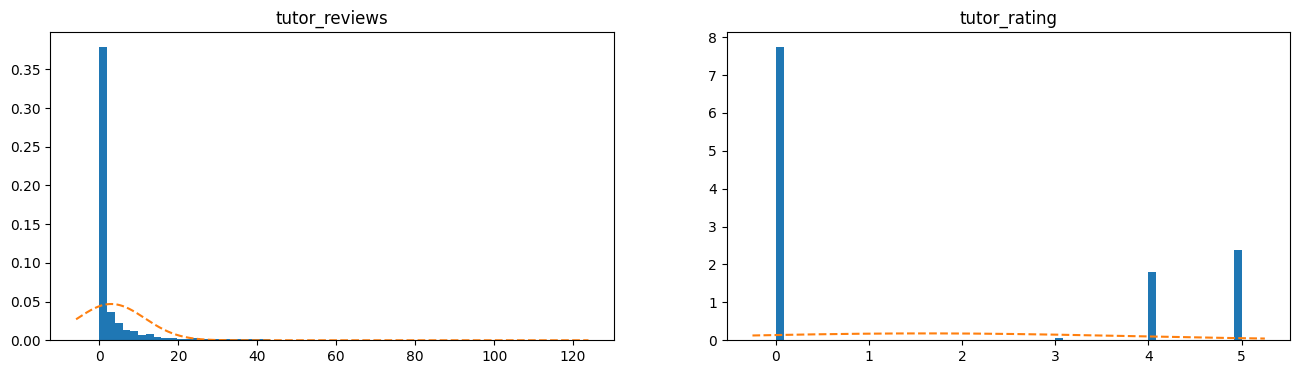

In [7]:
keys = ['tutor_reviews', 'tutor_rating']

fig, axes = plt.subplots(ncols=len(keys))
fig.set_size_inches(8 * len(keys), 4)
axes = axes.flatten()

for key, ax in zip(keys, axes):
    ax.hist(test[key], density=True, bins=60)
    
    loc = test[key].mean()
    scale = test[key].std()
    
    x_left, x_right = ax.get_xlim()
    x = np.linspace(x_left, x_right, 10000)
    y = stats.norm.pdf(x, loc=loc, scale=scale)
    
    ax.plot(x, y, linestyle='dashed')
    ax.set_title(key)

0     2
1     7
2     0
3    19
4     0
Name: tutor_reviews, dtype: int64
0    5.0
1    4.0
2    0.0
3    4.0
4    0.0
Name: tutor_rating, dtype: float64
0    16.666667
1    11.666667
2    23.333333
3     0.116667
4    16.666667
Name: mean_price, dtype: float64


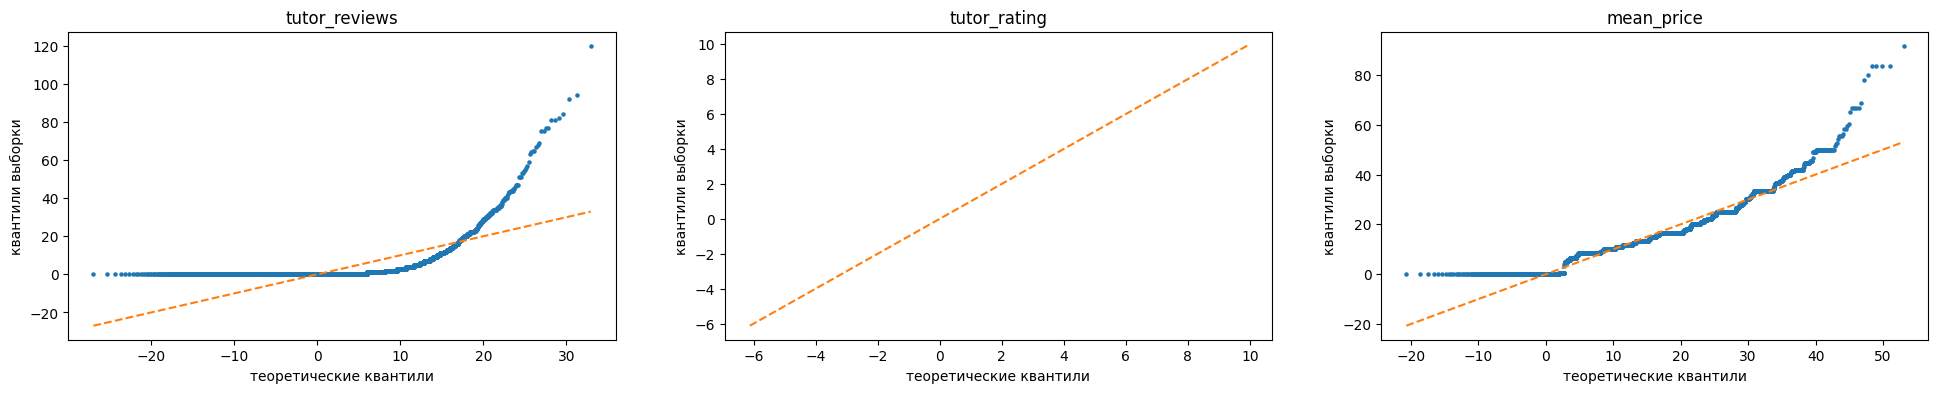

In [8]:
keys = ['tutor_reviews', 'tutor_rating', 'mean_price']

fig, axes = plt.subplots(ncols=len(keys))
fig.set_size_inches(8 * len(keys), 4)
axes = axes.flatten()

for key, ax in zip(keys, axes):
    samples = train[key]
    print(samples.head(5))
    
    loc = samples.mean()
    scale = samples.std()
    
    interval = np.linspace(0, 1, samples.shape[0])[1:-1]
    x = stats.norm.ppf(interval, loc=loc, scale=scale)
    y = np.quantile(samples, interval)
    
    ax.scatter(x, y, s=5)
    ax.plot(x, x, color='C1', linestyle='dashed')
    
    ax.set_title(key)
    ax.set_xlabel('теоретические квантили')
    ax.set_ylabel('квантили выборки')

In [9]:
for key in keys:
    print(key)
    samples = train[key]
    loc = samples.mean()
    scale = samples.std()
    for i in range(1, 4):
        true_value = stats.norm.cdf(i) - stats.norm.cdf(-i)
        sample_value = ((samples >= loc - i * scale) & (samples <= loc + i * scale)).sum() / samples.shape[0]
        
        print(f'{i} sigma(s)')
        print(f'\ttheoretical:\t{true_value}')
        print(f'\tsample:\t\t{sample_value}')
        
    print()

tutor_reviews
1 sigma(s)
	theoretical:	0.6826894921370859
	sample:		0.924802110817942
2 sigma(s)
	theoretical:	0.9544997361036416
	sample:		0.961301671064204
3 sigma(s)
	theoretical:	0.9973002039367398
	sample:		0.9769129287598944

tutor_rating
1 sigma(s)
	theoretical:	0.6826894921370859
	sample:		0.6576517150395779
2 sigma(s)
	theoretical:	0.9544997361036416
	sample:		0.8704925241864556
3 sigma(s)
	theoretical:	0.9973002039367398
	sample:		0.8704925241864556

mean_price
1 sigma(s)
	theoretical:	0.6826894921370859
	sample:		0.7700087950747582
2 sigma(s)
	theoretical:	0.9544997361036416
	sample:		0.9602022867194371
3 sigma(s)
	theoretical:	0.9973002039367398
	sample:		0.9870272647317502



Из графиков и квантильного анализ видно что ни одна из фич не имеет нормального распределения

# Проверка статистических гипотез


In [12]:
def var_analise(df, df1, df2, f):
    #размерности
    all1 = df1.shape[0] 
    all2 = df2.shape[0]
    # среднее выборочное в двух выборках и общее
    res1_mean = df1[f].mean()
    res2_mean = df2[f].mean()
    res_mean = df[f].mean()
    SS_b = all1 * (res1_mean - res_mean) ** 2 + all2 * (res2_mean - res_mean) ** 2
    SS_w = ((df1[f] - res1_mean) ** 2).sum() + ((df2[f]- res2_mean) ** 2).sum()

    k = 2
    n = all1 + all2
    k1 = k - 1
    k2 = n - k
    sigma2_b = SS_b / k1
    sigma2_w = SS_w / k2
    sigma2_b, sigma2_w

    F = sigma2_b / sigma2_w

    alpha = 0.05
    
    # находим критическую точку для гипотезы H1
    t = stats.f.ppf(1 - alpha, k1, k2)

    # Если наблюдаемое значение критерия, определенного по выборкам,
    # меньше критического значения, то нулевую гипотезу отвергают в пользу
    # альтернативной.
    return F>t


### Верно ли что люди с высоким рейтингом получают больше?

Да получается что люди которые получают более 2400 руб за час обладают большим рейтингом

In [22]:
df1 = train[train['mean_price'] >= 40]
df2 = train[train['mean_price'] < 40] 

In [23]:
var_analise(train, df1, df2, 'tutor_rating')

True

In [24]:
res1_mean = df1['tutor_rating'].mean()
res2_mean = df2['tutor_rating'].mean()

print(">= 40", res1_mean, "< 40", res2_mean)

>= 40 2.5245901639344264 < 40 1.8759447485014333


Верно ли что люди с большим количеством отзывов идеют больший заработок?

In [31]:
df1 = train[train['mean_price'] >= 30]
df2 = train[train['mean_price'] < 30] 

In [32]:
var_analise(train, df1, df2, 'tutor_reviews')

True

In [34]:
res1_mean = df1['tutor_reviews'].mean()
res2_mean = df2['tutor_reviews'].mean()

print(">= 40", res1_mean, "< 40", res2_mean)

>= 40 5.237362637362637 < 40 2.7390666992426094


получаем что если у репетитора много отзывыв, то он получает больше (более 1800) хотя влияние меньше чем рейтинг, видимо отзывов может быть много и негативных 